# A Tutorial on Multi-Armed Bandits with Per-Arm Features

This tutorial is a step-by-step guide on how to use the TF-Agents library for contextual bandits problems where the actions (arms) have their own features, such as a list of movies represented by features (genre, year of release, ...).

## Multi-Armed Bandits with Arm Features
In the "classic" Contextual Multi-Armed Bandits setting, an agent receives a context vector (aka observation) at every time step and has to choose from a finite set of numbered actions (arms) so as to maximize its cumulative reward.


Now consider the scenario where an agent recommends to a user the next movie to watch. Every time a decision has to be made, the agent receives as context some information about the user (watch history, genre preference, etc...), as well as the list of movies to choose from.

We could try to formulate this problem by having the user information as the context and the arms would be `movie_1, movie_2, ..., movie_K`, but this approach has multiple shortcomings:


*   The number of actions would have to be all the movies in the system and it is cumbersome to add a new movie.
*   The agent has to learn a model for every single movie.
*   Similarity between movies is not taken into account.

Instead of numbering the movies, we can do something more intuitive: we can represent movies with a set of features including genre, length, cast, rating, year, etc. The advantages of this approach are manifold:

*   Generalisation across movies.
*   The agent learns just one reward function that models reward with user and movie features.
*   Easy to remove from, or introduce new movies to the system.

In this new setting, the number of actions does not even have to be the same in every time step.



## Per-Arm Bandits in TF-Agents
The TF-Agents Bandit suite is developed so that one can use it for the per-arm case as well. There are per-arm environments, and also most of the policies and agents can operate in per-arm mode.

Before we dive into coding an example, we need the necessery imports.

In [1]:
# !pip install tf-agents
# !pip install tf-keras

In [2]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

### Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.environments import stationary_stochastic_per_arm_py_environment as p_a_env
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import tf_py_environment
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts

nest = tf.nest

2025-07-07 16:11:11.143914: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-07 16:11:11.158476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751904671.170889      27 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751904671.174352      27 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-07 16:11:11.187439: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [16]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
import tf_agents
import tf_keras

tf.__version__, tf_agents.__version__, tf_keras.__version__, np.__version__

('2.18.1', '0.19.0', '2.18.0', '1.26.2')

### Parameters -- Feel Free to Play Around

In [5]:
# The dimension of the global features.
GLOBAL_DIM = 40  #@param {type:"integer"}
# The elements of the global feature will be integers in [-GLOBAL_BOUND, GLOBAL_BOUND).
GLOBAL_BOUND = 10  #@param {type:"integer"}
# The dimension of the per-arm features.
PER_ARM_DIM = 50  #@param {type:"integer"}
# The elements of the PER-ARM feature will be integers in [-PER_ARM_BOUND, PER_ARM_BOUND).
PER_ARM_BOUND = 6  #@param {type:"integer"}
# The variance of the Gaussian distribution that generates the rewards.
VARIANCE = 100.0  #@param {type: "number"}
# The elements of the linear reward parameter will be integers in [-PARAM_BOUND, PARAM_BOUND).
PARAM_BOUND = 10  #@param {type: "integer"}

NUM_ACTIONS = 70  #@param {type:"integer"}
BATCH_SIZE = 20  #@param {type:"integer"}

# Parameter for linear reward function acting on the
# concatenation of global and per-arm features.
reward_param = list(np.random.randint(
      -PARAM_BOUND, PARAM_BOUND, [GLOBAL_DIM + PER_ARM_DIM]))

### A Simple Per-Arm Environment

The stationary stochastic environment, explained in the other [tutorial](https://github.com/tensorflow/agents/tree/master/docs/tutorials/bandits_tutorial.ipynb), has a per-arm counterpart.

To initialize the per-arm environment, one has to define functions that generate
*   *global and per-arm features*: These functions have no input parameters and generate a single (global or per-arm) feature vector when called.
*   *rewards*: This function takes as parameter the concatenation of a global and a per-arm feature vector, and generates a reward. Basically this is the function that the agent will have to "guess". It is worth noting here that in the per-arm case the reward function is identical for every arm. This is a fundamental difference from the classic bandit case, where the agent has to estimate reward functions for each arm independently.


In [6]:
def global_context_sampling_fn():
  """This function generates a single global observation vector."""
  return np.random.randint(
      -GLOBAL_BOUND, GLOBAL_BOUND, [GLOBAL_DIM]).astype(np.float32)

def per_arm_context_sampling_fn():
  """"This function generates a single per-arm observation vector."""
  return np.random.randint(
      -PER_ARM_BOUND, PER_ARM_BOUND, [PER_ARM_DIM]).astype(np.float32)

def linear_normal_reward_fn(x):
  """This function generates a reward from the concatenated global and per-arm observations."""
  mu = np.dot(x, reward_param)
  return np.random.normal(mu, VARIANCE)

Now we are equipped to initialize our environment.

In [7]:
per_arm_py_env = p_a_env.StationaryStochasticPerArmPyEnvironment(
    global_context_sampling_fn,
    per_arm_context_sampling_fn,
    NUM_ACTIONS,
    linear_normal_reward_fn,
    batch_size=BATCH_SIZE
)
per_arm_tf_env = tf_py_environment.TFPyEnvironment(per_arm_py_env)

Below we can check what this environment produces.

In [8]:
print('observation spec: ', per_arm_tf_env.observation_spec())
print('\nAn observation: ', per_arm_tf_env.reset().observation)

action = tf.zeros(BATCH_SIZE, dtype=tf.int32)
time_step = per_arm_tf_env.step(action)
print('\nRewards after taking an action: ', time_step.reward)

observation spec:  {'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None), 'per_arm': TensorSpec(shape=(70, 50), dtype=tf.float32, name=None)}

An observation:  {'global': <tf.Tensor: shape=(20, 40), dtype=float32, numpy=
array([[  4.,   5., -10.,  -6.,   7.,  -3.,  -8.,  -7.,  -3.,   3.,  -4.,
         -1.,   7.,  -4.,   0.,   2.,  -4.,  -8.,   9.,  -9.,   5.,  -8.,
        -10.,  -7.,   5.,  -4.,  -4.,   9.,  -8.,   7.,   2.,   7.,  -6.,
         -1.,   6.,  -8.,  -5.,  -2.,  -9.,  -4.],
       [ -3.,  -2.,   5., -10.,   2.,   7.,  -1.,  -5.,   9.,   4.,   7.,
          0.,  -2.,  -3.,   0., -10.,  -5.,   8.,   4.,  -3.,  -5.,  -1.,
          1.,  -1.,   4.,   8.,   3.,  -3.,  -6.,   2., -10.,  -8.,  -5.,
          9.,  -9.,  -8.,   5.,   9.,   3.,   7.],
       [ -9.,   1.,   5.,  -9.,   4.,   4.,  -9.,  -5.,   5.,  -6.,  -8.,
          9.,   3.,  -3.,   4.,   2., -10.,  -5.,   7.,  -3.,  -5.,   2.,
          4.,  -4.,  -6.,  -8.,  -8.,  -5.,  -7.,   6.,   8.,   2.,  -1.,
 

2025-07-07 16:11:12.438420: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (34)


We see that the observation spec is a dictionary with two elements:


*   One with key `'global'`: this is the global context part, with shape matching the parameter `GLOBAL_DIM`.
*   One with key `'per_arm'`: this is the per-arm context, and its shape is `[NUM_ACTIONS, PER_ARM_DIM]`. This part is the placeholder for the arm features for every arm in a time step.



### The LinUCB Agent

The LinUCB agent implements the identically named Bandit algorithm, which estimates the parameter of the linear reward function while also maintains a confidence ellipsoid around the estimate. The agent chooses the arm that has the highest estimated expected reward, assuming that the parameter lies within the confidence ellipsoid.

Creating an agent requires the knowledge of the observation and the action specification. When defining the agent, we set the boolean parameter `accepts_per_arm_features` set to `True`.

In [9]:
observation_spec = per_arm_tf_env.observation_spec()
time_step_spec = ts.time_step_spec(observation_spec)
action_spec = tensor_spec.BoundedTensorSpec(
    dtype=tf.int32, shape=(), minimum=0, maximum=NUM_ACTIONS - 1)

agent = lin_ucb_agent.LinearUCBAgent(time_step_spec=time_step_spec,
                                     action_spec=action_spec,
                                     accepts_per_arm_features=True)

### The Flow of Training Data

This section gives a sneak peek into the mechanics of how per-arm features go from the policy to training. Feel free to jump to the next section (Defining the Regret Metric) and come back here later if interested.

First, let us have a look at the data specification in the agent. The `training_data_spec` attribute of the agent specifies what elements and structure the training data should have.

In [10]:
print('training data spec: ', agent.training_data_spec)

training data spec:  Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': DictWrapper({'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None)}),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(69, dtype=int32)),
 'policy_info': PerArmPolicyInfo(log_probability=(), predicted_rewards_mean=(), multiobjective_scalarized_predicted_rewards_mean=(), predicted_rewards_optimistic=(), predicted_rewards_sampled=(), bandit_policy_type=(), chosen_arm_features=TensorSpec(shape=(50,), dtype=tf.float32, name=None)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})


If we have a closer look to the `observation` part of the spec, we see that it does not contain per-arm features!

In [11]:
print('observation spec in training: ', agent.training_data_spec.observation)

observation spec in training:  {'global': TensorSpec(shape=(40,), dtype=tf.float32, name=None)}


What happened to the per-arm features? To answer this question, first we note that when the LinUCB agent trains, it does not need the per-arm features of **all** arms, it only needs those of the **chosen** arm. Hence, it makes sense to drop the tensor of shape `[BATCH_SIZE, NUM_ACTIONS, PER_ARM_DIM]`, as it is very wasteful, especially if the number of actions is large.

But still, the per-arm features of the chosen arm must be somewhere! To this end, we make sure that the LinUCB policy stores the features of the chosen arm within the `policy_info` field of the training data:

In [12]:
print('chosen arm features: ', agent.training_data_spec.policy_info.chosen_arm_features)

chosen arm features:  TensorSpec(shape=(50,), dtype=tf.float32, name=None)


We see from the shape that the `chosen_arm_features` field has only the feature vector of one arm, and that will be the chosen arm. Note that the `policy_info`, and with it the `chosen_arm_features`, is part of the training data, as we saw from inspecting the training data spec, and thus it is available at training time.

### Defining the Regret Metric

Before starting the training loop, we define some utility functions that help calculate the regret of our agent. These functions help determining the optimal expected reward given the set of actions (given by their arm features) and the linear parameter that is hidden from the agent.

In [13]:
def _all_rewards(observation, hidden_param):
  """Outputs rewards for all actions, given an observation."""
  hidden_param = tf.cast(hidden_param, dtype=tf.float32)
  global_obs = observation['global']
  per_arm_obs = observation['per_arm']
  num_actions = tf.shape(per_arm_obs)[1]
  tiled_global = tf.tile(
      tf.expand_dims(global_obs, axis=1), [1, num_actions, 1])
  concatenated = tf.concat([tiled_global, per_arm_obs], axis=-1)
  rewards = tf.linalg.matvec(concatenated, hidden_param)
  return rewards

def optimal_reward(observation):
  """Outputs the maximum expected reward for every element in the batch."""
  return tf.reduce_max(_all_rewards(observation, reward_param), axis=1)

regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward)

Now we are all set for starting our bandit training loop. The driver below takes care of choosing actions using the policy, storing rewards of chosen actions in the replay buffer, calculating the predefined regret metric, and executing the training step of the agent.

In [14]:
num_iterations = 20 # @param
steps_per_loop = 1 # @param

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=steps_per_loop)

observers = [replay_buffer.add_batch, regret_metric]

driver = dynamic_step_driver.DynamicStepDriver(
    env=per_arm_tf_env,
    policy=agent.collect_policy,
    num_steps=steps_per_loop * BATCH_SIZE,
    observers=observers)

regret_values = []

for _ in range(num_iterations):
  driver.run()
  loss_info = agent.train(replay_buffer.gather_all())
  replay_buffer.clear()
  regret_values.append(regret_metric.result())


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


 Now let's see the result. If we did everything right, the agent is able to estimate the linear reward function well, and thus the policy can pick actions whose expected reward is close to that of the optimal. This is indicated by our above defined regret metric, which goes down and approaches zero.

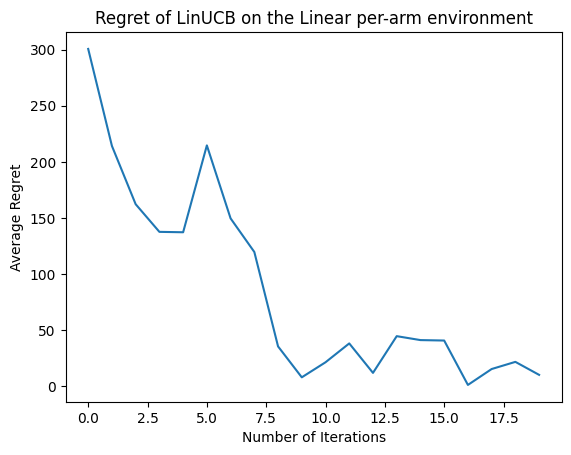

In [15]:
plt.plot(regret_values)
plt.title('Regret of LinUCB on the Linear per-arm environment')
plt.xlabel('Number of Iterations')
_ = plt.ylabel('Average Regret')

### What's Next?
The above example is [implemented](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/examples/v2/train_eval_per_arm_stationary_linear.py) in our codebase where you can choose from other agents as well, including the [Neural epsilon-Greedy agent](https://github.com/tensorflow/agents/blob/master/tf_agents/bandits/agents/neural_epsilon_greedy_agent.py).